In [0]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
from io import StringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np 


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_all = pd.read_csv('/content/drive/My Drive/Thesis/DHS_nightlights.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(0.0, 50.0)

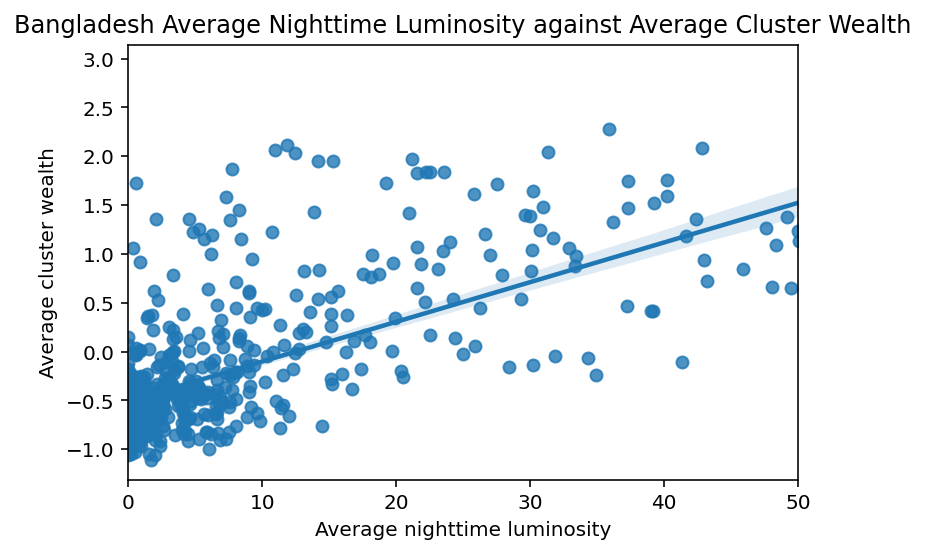

In [4]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

ax = sns.regplot(x="mean_", y="wealth", data=data_all)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.title("Bangladesh Average Nighttime Luminosity against Average Cluster Wealth")
plt.xlim([0, 50])


In [9]:
#fit a model of wealth as a function of nightlights 

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge


data_all = data_all[['max_', 'min_', 'mean_', 'median_', 'std_', 'wealth']].values
np.random.seed(123)

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Ridge(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')

R^2 of the best model: 0.6001952206605662


In [10]:
from sklearn.linear_model import Lasso

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = Lasso(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')

R^2 of the best model: 0.5969722054084954


In [11]:
from sklearn.linear_model import ElasticNet

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = ElasticNet(alpha=alpha)
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')


R^2 of the best model: 0.586808396578341


In [13]:
from sklearn.ensemble import RandomForestRegressor

alphas_list = np.logspace(-1, 5, 7)
final = []
for alpha in alphas_list:
    kf = KFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(data_all):
        reg = RandomForestRegressor()
        train = data_all[train_index]
        test = data_all[test_index]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

print(f'R^2 of the best model: {np.max(final)}')


R^2 of the best model: 0.5932739964720369


In [0]:
class Metrics(object):
  """Performance metrics for regressor."""

  def __init__(self, y_true, predictions):
    self.y_true = y_true
    self.predictions = predictions
    self.residuals = self.y_true - self.predictions
    self.rmse = self.calculate_rmse(self.residuals)
    self.mae = self.calculate_mae(self.residuals)
    self.malr = self.calculate_malr(self.y_true, self.predictions)

  def calculate_rmse(self, residuals):
    """Root mean squared error."""
    return np.sqrt(np.mean(np.square(residuals)))

  def calculate_mae(self, residuals):
    """Mean absolute error."""
    return np.mean(np.abs(residuals))

  def calculate_malr(self, y_true, predictions):
    """Mean absolute log ratio."""
    return np.mean(np.abs(np.log(1 + predictions) - np.log(1 + y_true)))

  def report(self, name=None):
    if name is not None:
      print_string = '{} results'.format(name)
      print(print_string)
      print('~' * len(print_string))
    print('RMSE: {:2.3f}\nMAE: {:2.3f}\nMALR: {:2.3f}'.format(
        self.rmse, self.mae, self.malr))


In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)
scores = []
for train_index, test_index in kf.split(data_all):
  train = data_all[train_index]
  test = data_all[test_index]
  xgb = XGBRegressor()
  xgb.fit(train[:, :-1], train[:, -1])
  xgb_pred = xgb.predict(test[:, :-1])
  XGBoost_metrics = Metrics(test[:, -1], xgb_pred)
#  XGBoost_metrics.report("XGBoost")

# Look at the R^2 scores on train and test
print("R2 train: ", xgb.score(train[:, :-1], train[:, -1]))
print("R2 test: ", xgb.score(test[:, :-1], test[:, -1]))



/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


[07:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:20:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re